<a href="https://colab.research.google.com/github/Cocobolo0/Cocobolo0/blob/main/Water_Pumping_Simulation_V3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## DEFINICIONES
import sympy as sp
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class Reservoir:
    def __init__(self, name, initial_level, max_level, volume_function):
        self.name = name  # Name of the reservoir
        self.initial_level = initial_level  # meters (current water level)
        self.max_level = max_level  # meters (maximum water level)
        self.volume_function = volume_function  # Function defining volume in terms of height

    def __str__(self):
        return self.name

    def volume(self, level):
        """Calculate the volume of water up to a given level using integration"""
        h = sp.Symbol('h')
        return sp.integrate(self.volume_function, (h, 0, level)).evalf()

    def capacity(self):
        """Calculate the total capacity of the reservoir"""
        return self.volume(self.max_level)

    def level_from_volume(self, volume):
        """Estimate the water level from a given volume by solving the equation numerically."""
        h = sp.Symbol('h')
        equation = sp.integrate(self.volume_function, (h, 0, h)) - volume
        return sp.nsolve(equation, h, self.initial_level)

class Pump:
    def __init__(self, name, flow_rate, upstream, downstream, upstream_min, upstream_max, downstream_min, downstream_max):
        self.name = name

        self.flow_rate = flow_rate  # Flow rate in liters per second (L/s)
        self.upstream = upstream  # Name of the reservoir upstream (Source)
        self.downstream = downstream  # Name of the reservoir downstream (Destination)
        self.upstream_min = upstream_min  # Minimum level in upstream pond to operate
        self.upstream_max = upstream_max  # Maximum level in upstream pond to operate
        self.downstream_min = downstream_min  # Minimum level in downstream pond to operate
        self.downstream_max = downstream_max  # Maximum level in downstream pond to operate
        self.switch_up = True
        self.switch_down = True
        self.state_on = self.switch_up and self.switch_down
        self.route = f"{upstream}_to_{downstream}"

    def turn_on(self):
        """Turns the pump on."""
        self.state_on = True

    def turn_off(self):
        """Turns the pump off."""
        self.state_on = False

    def update_state(self, upstream_level, downstream_level):
        """Updates the pump state based on upstream and downstream levels."""
        # Control the upstream switch
        if upstream_level >= self.upstream_max:
            self.switch_up = True
        elif upstream_level <= self.upstream_min:
            self.switch_up = False

        # Control the downstream switch
        if downstream_level >= self.downstream_max:
            self.switch_down = False
        elif downstream_level <= self.downstream_min:
            self.switch_down = True

        # Update pump state based on switch conditions
        self.state_on = self.switch_up and self.switch_down

def calculate_total_flow(pumps):
    """Calcula el flujo total por ruta considerando solo las bombas encendidas."""
    total_flows = {}
    for pump in pumps:
        if pump.state_on:
            total_flows[pump.route] = total_flows.get(pump.route, 0) + pump.flow_rate
    return total_flows

def generate_routes(csv_file):
    # Leer el archivo CSV
    df = pd.read_csv(csv_file, dtype={"cod": str, "UPSTREAM": str, "DOWNSTREAM": str})

    # Crear un conjunto para almacenar rutas únicas
    routes = set()

    # Recorrer las filas del DataFrame y generar las rutas
    for _, row in df.iterrows():
        route = (f"{row['UPSTREAM']}_to_{row['DOWNSTREAM']}", row['UPSTREAM'], row['DOWNSTREAM'])
        routes.add(route)

    # Convertir a lista ordenada
    # return sorted(routes)
    return list(routes)

In [ ]:
## CÓDIGO DE LA SIMULACIÓN

def pump_water_simultaneously(pumps, reservoirs, routes, total_hours=1, interval_seconds=1):

    # Definiendo Diccionarios de volumen inicial, nivel actual, transferido por ruta, transferido por bomba
    initial_volumes = {key: reservoir.volume(reservoir.initial_level) for key, reservoir in reservoirs.items()}
    current_levels = {key: reservoir.level_from_volume(initial_volumes[key]) for key, reservoir in reservoirs.items()}
    trnsf_by_pmp = {pump.name: [0, pump.upstream, pump.downstream] for pump in pumps}
    transferred = {key[0]: [0, key[1], key[2]] for key in routes}

    # Definiendo Diccionarios para históricos relativos a bombas y pozas
    historic_levels = {key: [] for key in reservoirs}
    historic_pmp_by_pmp = {pump.name: [] for pump in pumps}
    historic_trnsf_by_pump = {pump.name: [[], pump.upstream, pump.downstream] for pump in pumps}
    historic_pump_states = {pump.name: [] for pump in pumps}
    historic_pumped = {key[0]: [] for key in routes}
    historic_transferred = {key[0]: [] for key in routes}

    # Definiendo flujo total por ruta
    total_flows = calculate_total_flow(pumps)

    # Definiendo el parámetro TIEMPO
    time_step = interval_seconds
    total_steps = int((total_hours * 3600) / time_step)
    historic_steps = []
    #_____________LOOPING SIMULATION______________

    for step in range(total_steps):
        if (step + 1)  % 3600 == 0:
            print(f"Step: {((step + 1)/3600)} h.")
        # Guardar el paso en la historia
        historic_steps.append(step)

        pumped = {key[0]: 0.0 for key in routes}
        pmp_by_pmp = {pump.name: 0 for pump in pumps}


        # Flujo bombead por BOMBA
        for pump in pumps:
            pump.update_state(current_levels[str(pump.upstream)], current_levels[str(pump.downstream)])

            key = f"{str(pump.upstream)}_to_{str(pump.downstream)}"
            if pump.state_on:
                pmp_by_pmp[pump.name] = pump.flow_rate * time_step / 1000
                trnsf_by_pmp[pump.name][0] += pmp_by_pmp[pump.name]
            else:
                pmp_by_pmp[pump.name] = 0

            # Agregar valor bombeado y transferido total por BOMBA a Historico
            historic_pmp_by_pmp[pump.name].append(pmp_by_pmp[pump.name])
            historic_trnsf_by_pump[pump.name][0].append(trnsf_by_pmp[pump.name][0])
            historic_pump_states[pump.name].append(pump.state_on)

        # Flujo bombeado por RUTA
        total_flows = calculate_total_flow(pumps)

        for route in routes:
            key = route[0]
            pumped[key] = total_flows.get(key, 0) * time_step / 1000  # Use get to handle missing keys
            transferred[key][0] += pumped[key]

            # # Agregar valor bombeado y transferido total por RUTA a Historico
            historic_pumped[key].append(pumped[key])
            historic_transferred[key].append(transferred[key][0])


        # Actualizar niveles actuales de los reservorios
        for i, res in enumerate(reservoirs):

            current_level = getattr(reservoirs[str(res)], "level_from_volume")(
                initial_volumes[str(res)] +
                sum(transferred[key[0]][0] for key in routes if transferred[key[0]][2] == str(res)) -
                sum(transferred[key[0]][0] for key in routes if transferred[key[0]][1] == str(res))
            )

            # Agregar nivel actual al historico
            current_levels[str(res)] = current_level
            historic_levels[res].append(current_level)

    return historic_steps, historic_pumped, historic_levels, historic_transferred, historic_pmp_by_pmp, historic_trnsf_by_pump, historic_pump_states


In [ ]:
# PARÁMETROS DE EJECUCIÓN

# Example usage
h = sp.Symbol('h')

pumps_csv_file = "bombas_27.03_V3_03.csv"
reservoirs_csv_file = "pozas_V3_04.csv"

# Leer la tabla desde un archivo CSV o definirla directamente
data_pumps = pd.read_csv(pumps_csv_file, dtype={"cod": str, "UPSTREAM": str, "DOWNSTREAM": str})  # Asegúrate de que el archivo CSV tenga las columnas correctas
data_reservoirs = pd.read_csv(reservoirs_csv_file, dtype = {"NAME": str})

# Crear lista de objetos Pumps, reservoirs y rutas
pumps = [
    Pump(row.cod, row.FLOW, row.UPSTREAM, row.DOWNSTREAM,
         row.UP_MIN, row.UP_MAX, row.DOWN_MIN, row.DOWN_MAX)
    for row in data_pumps.itertuples(index=False)
]

reservoirs = {
    row.NAME: Reservoir(row.NAME, row.INITIAL_LEVEL, row.MAX_LEVEL, row.VOLUME_FUNCTION)
    for row in data_reservoirs.itertuples(index=False)
}

routes = generate_routes(pumps_csv_file)

# Parámetros de TIEMPO de simulación
total_hours = 24  # Tiempo total de simulación en horas
interval_seconds = 1  # Intervalo de tiempo en segundos

# Ejecutar simulación
test = pump_water_simultaneously(pumps, reservoirs, routes, total_hours)

Step: 1.0 h.
Step: 2.0 h.
Step: 3.0 h.
Step: 4.0 h.
Step: 5.0 h.
Step: 6.0 h.
Step: 7.0 h.
Step: 8.0 h.
Step: 9.0 h.
Step: 10.0 h.
Step: 11.0 h.
Step: 12.0 h.
Step: 13.0 h.
Step: 14.0 h.
Step: 15.0 h.
Step: 16.0 h.
Step: 17.0 h.
Step: 18.0 h.
Step: 19.0 h.
Step: 20.0 h.
Step: 21.0 h.
Step: 22.0 h.
Step: 23.0 h.
Step: 24.0 h.


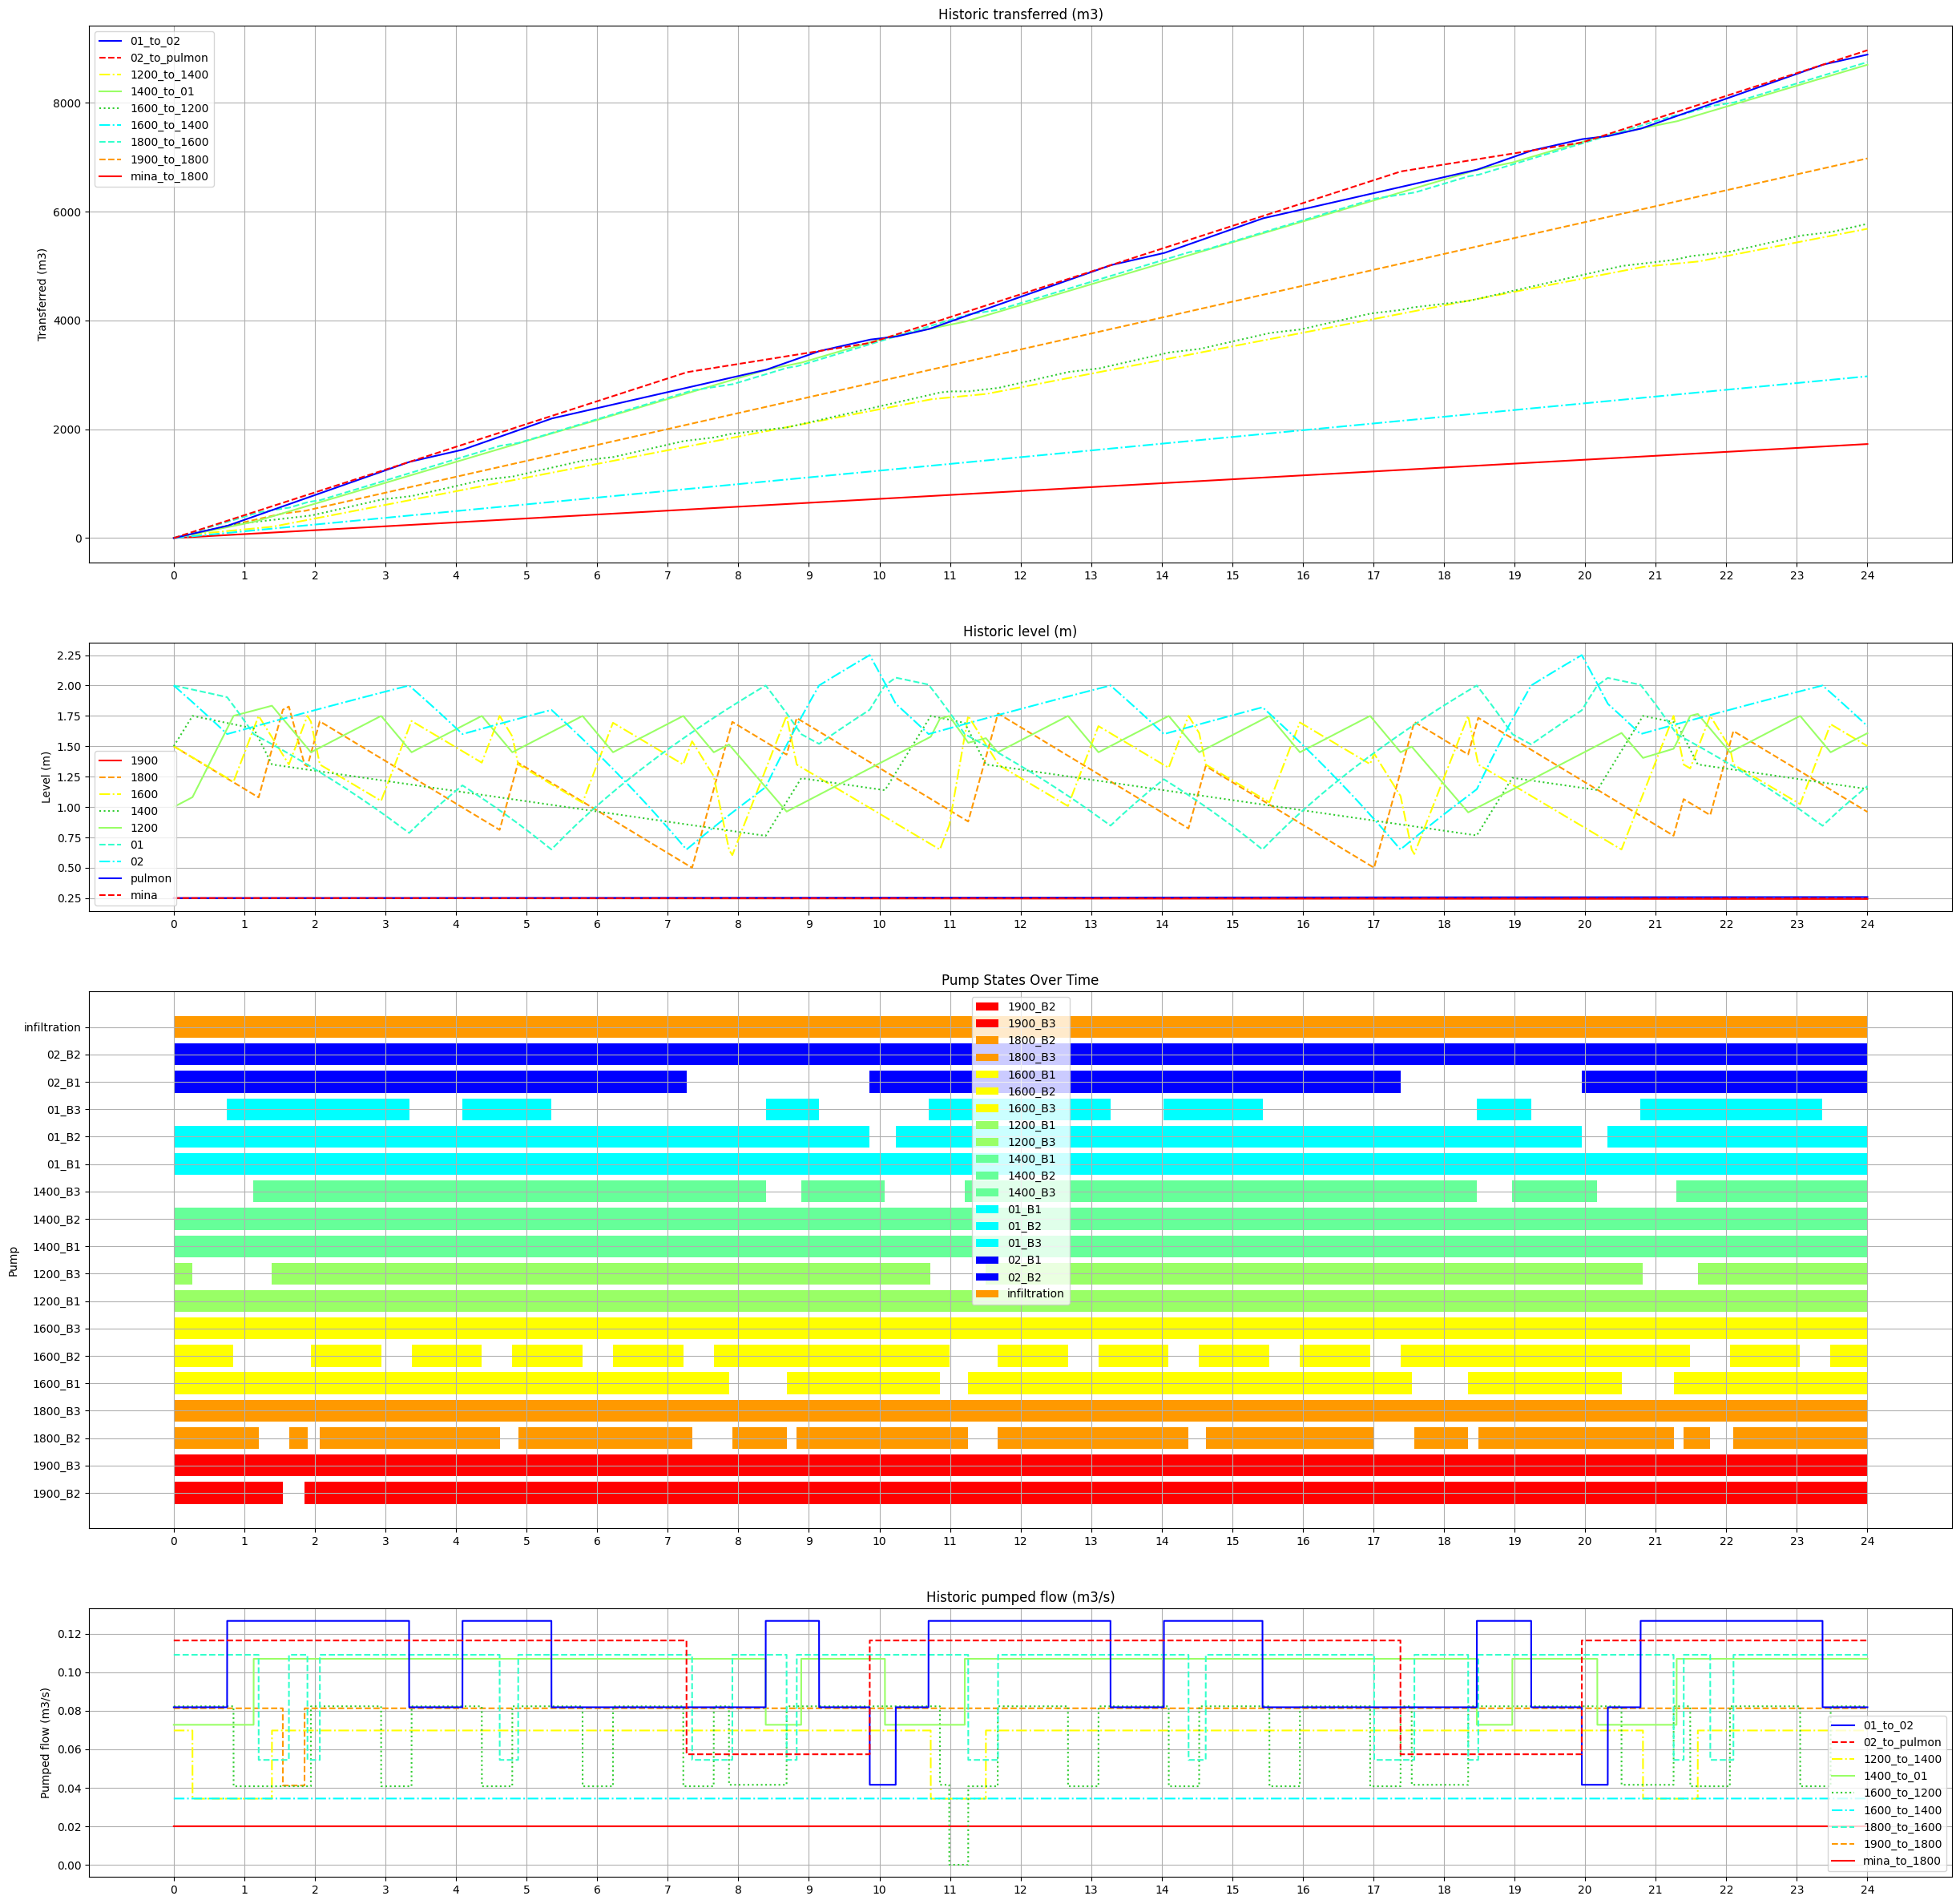

In [ ]:
################### GRAFICOS ############################
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

steps_format = [x / 3600 for x in test[0]] # Ejes a segundos


colors = [
    "#FF0000",  # Rojo
    "#FF9900",  # Naranja
    "#FFFF00",  # Amarillo
    # "#CCFF33",  # Lima
    "#32CD32",  # Verde lima oscuro
    "#99FF66",  # Verde claro
    "#33FFCC",  # Turquesa
    "#00FFFF",  # Cian
    "#0000FF"   # Azul puro
]

# Datos
colors_pumps = [
    "#FF0000",  # 1900 B2
    "#FF0000",  # 1900 B3
    # "#FF0000",  # 1900 BN    bomba nuevaaaaaaaaaaa
    "#FF9900",  # 1800 B2
    "#FF9900",  # 1800 B3
    "#FFFF00",  # 1600 B1
    "#FFFF00",  # 1600 B2
    "#FFFF00",  # 1600 B3
    "#99FF66",  # 1200 B2
    "#99FF66",  # 1200 B3
    "#66FF99",  # 1400 B1
    "#66FF99",  # 1400 B2
    "#66FF99",  # 1400 B3
    "#00FFFF",  # 01 B1
    "#00FFFF",  # 01 B2
    "#00FFFF",  # 01 B3
    "#0000FF",  # 02 B2
    "#0000FF",   # 02 B3
    "#FF9900"  # infiltraciooooooooooooooon
]

reservoir_labels = [i[1] for i in enumerate(reservoirs)]
pump_labels = [pump.name for pump in pumps ]

# Crear la figura con subgráficos
fig, axs = plt.subplots(4, 1, figsize=(30, 30), gridspec_kw={'height_ratios': [20, 10, 20, 10], 'hspace': 0.2})

def plot_lines(ax, indices, ylabel, title):
    linestyles = ["-", "--", "-.", ":", "-", "--", "-."]
    legend_entries = []  # Store (label, handle) pairs

    for i, idx in enumerate(indices):
        linestyle = linestyles[i % len(linestyles)]
        line, = ax.plot(steps_format, indices[i], label=routes[i][0], color=colors[i % len(colors)], linestyle=linestyle)
        legend_entries.append((routes[i][0], line))  # Save label and line handle


    # Sort legend entries alphabetically by label
    legend_entries.sort(key=lambda x: x[0])

    # Unpack sorted labels and handles
    sorted_labels, sorted_handles = zip(*legend_entries)

    ax.set_xticks(range(int(min(steps_format)), int(max(steps_format)) + 2 , 1))
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(sorted_handles, sorted_labels)  # Apply sorted legend
    ax.grid(True)

def plot_lines2(ax, indices, ylabel, title):
    linestyles = ["-", "--", "-.", ":", "-", "--", "-."]
    for i, idx in enumerate(indices):
        linestyle = linestyles[i % len(linestyles)]
        ax.plot(steps_format, indices[i], label=reservoir_labels[i], color=colors[i % len(colors)], linestyle=linestyle)
        ax.set_xticks(range(int(min(steps_format)), int(max(steps_format)) + 2 , 1))
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

def plot_lines3(ax, indices, ylabel, title):
    linestyles = ["-", "--", "-.", ":", "-", "--", "-."]
    for i, idx in enumerate(indices):
        linestyle = linestyles[i % len(linestyles)]
        ax.plot(steps_format, indices[i], label=pump_labels[i], color=colors[i % len(colors)], linestyle=linestyle)
        ax.set_xticks(range(int(min(steps_format)), int(max(steps_format)) + 2 , 1))
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

# Dibujar barras para cada bomba
hist_state_list = []
for i in test[6]:
    hist_state_list.append(test[6][i])

ax_broken = axs[2]
for i, (state_list, color, label) in enumerate(zip(hist_state_list, colors_pumps, pump_labels)):
    segments = []
    start = None

    for j, value in enumerate(state_list):
        if value == 1 and start is None:
            start = j  # Inicia el segmento cuando el estado es 1
        elif value == 0 and start is not None:
            segments.append((start, j - start))  # Guarda el segmento (inicio, duración)
            start = None

    if start is not None:
        segments.append((start, len(state_list) - start))  # Último segmento abierto

    # Dibujar los segmentos en el gráfico
    ax_broken.broken_barh(segments, (i - 0.4, 0.8), facecolors=colors_pumps[i % len(colors_pumps)], label=label)

ax_broken.set_ylabel("Pump")
ax_broken.set_title("Pump States Over Time")
ax_broken.set_yticks(range(len(pump_labels)))
ax_broken.set_yticklabels(pump_labels)
ax_broken.set_xticks(range(0, len(test[0]) + 1 , 3600))
ax_broken.set_xticklabels(int(i/3600) for i in range(0, len(test[0]) + 1, 3600))
ax_broken.legend()
ax_broken.grid(True)


# Gráficos
plot_lines(axs[0], [test[3].get(i) for i in test[3]], "Transferred (m3)", "Historic transferred (m3)")

plot_lines2(axs[1], [test[2].get(i) for i in test[2]], "Level (m)", "Historic level (m)")

plot_lines(axs[3], [test[1].get(i) for i in test[1]], "Pumped flow (m3/s)", "Historic pumped flow (m3/s)")

In [ ]:
print('1900_to_1800:', test[3]['1900_to_1800'][-1])
print('02_to_pulmon:', test[3]['02_to_pulmon'][-1])
# print(test[6][])

1900_to_1800: 6978.161200010033
02_to_pulmon: 8966.69460000344


In [ ]:
a  =[]
for i in test[6]:
    # print(sum(test[6]["1900_B2"]))

    # a.append((i, sum(test[6][i])))
    print(i, sum(test[6][i]))

# print(a)

1900_B2 85292
1900_B3 86400
1800_B2 74051
1800_B3 86400
1600_B1 76476
1600_B2 63976
1600_B3 86400
1200_B1 86400
1200_B3 76741
1400_B1 86400
1400_B2 86400
1400_B3 70586
01_B1 86400
01_B2 83746
01_B3 42918
02_B1 67806
02_B2 86400
infiltration 86400


In [ ]:
#### EXPORTAR

import pandas as pd

def export_simulation_results(historic_steps, historic_pumped, historic_levels, historic_transferred, historic_pmp_by_pmp, historic_trnsf_by_pump, historic_pump_states):
    """Exporta los resultados de la simulación a un solo archivo CSV."""

    # Crear un DataFrame con todos los datos
    results_df = pd.DataFrame({
        "Time Step": historic_steps,
        **{f"Level_{key}": values for key, values in historic_levels.items()},
        **{f"Pumped_{key}": values for key, values in historic_pumped.items()},
        **{f"Transferred_{key}": values for key, values in historic_transferred.items()},
        **{f"PumpedByPump_{key}": values for key, values in historic_pmp_by_pmp.items()},
        **{f"PumpState_{key}": values for key, values in historic_pump_states.items()}
    })

    # Exportar a un solo archivo CSV
    csv_results_file_name = f"simulation_results_{pumps_csv_file[:-4]}_{reservoirs_csv_file[:-4]}.csv"
    results_df.to_csv(csv_results_file_name, index=False)

    print(f"Resultados exportados a {csv_results_file_name} correctamente.")

# Usar los resultados de la simulación almacenados en 'test'
export_simulation_results(*test)

Resultados exportados a simulation_results_bombas_27.03_V3_03_pozas_V3_04.csv correctamente.
